# Decision trees

A decision tree is much like playing "Twenty Questions." A question is asked, and the answer reduces the possible results, leading to a new question. **CART** (Classification And Regression Tree) is a popular method for systematizing the idea.

Given samples $\bfx_1,\ldots,\bfx_n$ and labels $y_1,\ldots,y_n$, the immediate goal is to partition the samples into subsets whose labels are as uniform as possible. The process is then repeated recursively on the subsets. Defining a measurement of label uniformity is a key step. 

## Gini impurity

Let $S$ be a subset of the samples, given as a list of indices into the original set. Suppose there are $K$ unique labels, which we denote $1,2,\ldots,K$. Define

$$
p_k = \frac{1}{ |S| } \sum_{i\in S} \mathbb{1}_k(y_i),
$$

where $|S|$ is the number of elements in $S$ and $\mathbb{1}_k$ is the **indicator function**

$$
\mathbb{1}_k(t) = \begin{cases} 
  1, & \text{if } t=k, \\ 
  0, & \text{otherwise.}
  \end{cases}
$$

In words, $p_k$ is the proportion of samples in $S$ that have label $k$. Then the **Gini impurity** is defined as 

$$
H(S) = \sum_{k=1}^K p_k(1-p_k).
$$

If one of the $p_k$ is 1, then the others are all zero and $H(S)=0$. This is considered optimal. At the other extreme, if $p_k=1/K$ for all $k$, then 

$$
H(S) = \sum_{k=1}^K \frac{1}{K} \left(1 - \frac{1}{K} \right) = K\cdot \frac{1}{K}\cdot\frac{K-1}{K} = \frac{K-1}{K} < 1.
$$

::::{prf:example}
:label: example-decision-trees-gini
Suppose a set $S$ has $n$ members with label 1, 1 member with label 2, and 1 member with label 3. What is the Gini impurity of $S$?

:::{dropdown} Solution
We have $p_1=n/(n+2)$, $p_2=p_3=1/(n+2)$. Hence

$$
H(S) &= \frac{n}{n+2}\left( 1 - \frac{n}{n+2} \right) + 2 \frac{1}{n+2}\left( 1 - \frac{1}{n+2} \right) \\ 
&= \frac{n}{n+2}\frac{2}{n+2} + \frac{2}{n+2}\frac{n+1}{n+2} \\ 
&= \frac{4n+2}{(n+2)^2}.
$$

This value is 1/2 for $n=0$ and approaches zero as $n\to\infty$.
:::
::::

## Partitioning

Now we can describe the partition process. If $j$ is a dimension (feature) number and $\theta$ is a numerical threshold, then the sample set can be partitioned into complementary sets $S_L$, in which $x_j \le \theta$, and $S_R$, in which $x_j > \theta$. Define the quality measure

$$
Q(j,\theta) = |S| H(S) + |T| H(T).
$$

Choose the $(j,\theta)$ that minimize $Q$, and then recursively partition $S$ and $T$.

::::{prf:example}
:label: example-decision-trees-partition

Suppose the 1D real samples $0,1,2,3$ have labels A,B,A,B. What is the optimal partition?

:::{dropdown} Solution
There are three ways to partition them.

* $S=\{0\}$, $T=\{1,2,3\}$. We have $H(S)=0$ and $H(T)=(2/3)(1/3)+(1/3)(2/3)=4/9$. Hence the score for this partition is $(1)(0) + (3)(4/9) = 4/3$.
* $S=\{0,1\}$, $T=\{2,3\}$. Then $H(S)=H(T)=2(1/2)(1/2)=1/2$, and the composite score is $(2)(1/2)+(2)(1/2)=2$. 
* $S=\{0,1,2\}$, $T=\{3\}$. This arrangement is the same as the first case with $A↔B$.

The best partition threshold is $x\le 0$ (or $x\le 2$, which is equivalent).
:::
::::

## Toy example

We first create a toy dataset with 20 random points, with two subsets of 10 that are shifted left/right a bit.

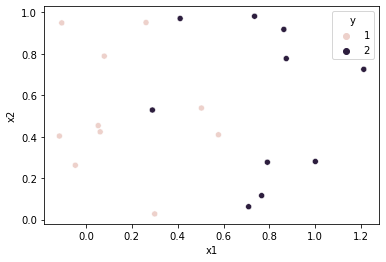

In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

rng = default_rng(1)
x1 = rng.random((10,2))
x1[:,0] -= 0.25
x2 = rng.random((10,2))
x2[:,0] += 0.25
X = np.vstack((x1,x2))
y = np.hstack(([1]*10,[2]*10))

import seaborn as sns
df = pd.DataFrame({"x1":X[:,0],"x2":X[:,1],"y":y})
sns.scatterplot(data=df,x="x1",y="x2",hue="y");

Now we create a decision tree for these samples.

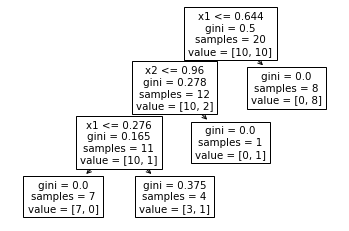

In [2]:
from sklearn import tree
t = tree.DecisionTreeClassifier(max_depth=3)
t.fit(X,y)

tree.plot_tree(t,feature_names=["x1","x2"]);

The root of the tree (at the top) shows that the best split was found at the vertical line $x_1=0.644$. To the right of that line is a Gini value of zero: 8 samples, all with label 2. Thus, any future prediction by this tree will immediately return label 2 if the first feature of the input exceeds 0.644. Otherwise, it moves to the left child node and tests whether the second feature is greater than $0.96$. This splits along a horizontal line, above which there is a single sample with label 2. And so on.

Notice that the bottom right node has a nonzero Gini impurity. This node could be partitioned, but the classifier was constrained to stop at a depth of 3. If a prediction ends up here, then the classifier returns label 1, which is the most likely outcome.

Because we can follow the decision tree's logic step by step, we say it is highly **interpretable**. The transparency of the prediction algorithm is an attractive aspect of decision trees. 

## Penguin data

We return to the penguins. There is no need to standardize the columns for a decision tree, because each dimension is considered on it own.

In [3]:
import pandas as pd
pen = sns.load_dataset("penguins")
pen = pen.dropna()
X = pen[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]]
y = pen["species"]

We again get some interesting information from a tree with limited depth.

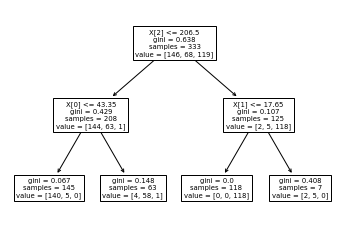

In [4]:
dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X,y)

tree.plot_tree(dt);

The most determinative feature for identifying the species is the flipper length. If it exceeds 206.5 mm, then the penguin is rather likely to be a Gentoo, and a further measurement of the bill depth settles that matter. Etc. Even for this shallow tree, two of the nodes at the bottom have small Gini impurity.

Next, we increase the depth and measure the performance. The resulting tree will be identical to the tree above for the first two levels, since the optimal decisions remain the same.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2)
dt = tree.DecisionTreeClassifier(max_depth=4)
dt.fit(X,y)

yhat = dt.predict(X_te)
print(confusion_matrix(y_te,yhat))
print(classification_report(y_te,yhat))

[[30  0  0]
 [ 0 10  0]
 [ 0  0 27]]
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        10
      Gentoo       1.00      1.00      1.00        27

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



## Limitations

Decision trees depend sensitively on the sample locations. A tree trained on one data subset may not do well on a new set. A small change can completely rewrite large parts of the tree, which gives a caveat about interpretation. Also, the partition algorithm, which is *greedy* by doing the best thing at the moment, does not necessarily find a globally optimal tree, or even a nearby one. 

Here we see mediocre performance on the loan application data.

In [6]:
import numpy as np
X = np.loadtxt("data.csv",delimiter=",")
y = np.loadtxt("labels.csv",delimiter=",")
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2)

dt = tree.DecisionTreeClassifier(max_depth=5)
dt.fit(X_tr,y_tr)
yhat = dt.predict(X_te)
print(confusion_matrix(y_te,yhat))
print(classification_report(y_te,yhat))

[[664   1]
 [145  18]]
              precision    recall  f1-score   support

        -1.0       0.82      1.00      0.90       665
         1.0       0.95      0.11      0.20       163

    accuracy                           0.82       828
   macro avg       0.88      0.55      0.55       828
weighted avg       0.85      0.82      0.76       828



To deal with these issues and more, you can try a **random forest**, which consists of many trees trained on subsets of the original features and datasets.

In [7]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500,max_features=6)
rf.fit(X_tr,y_tr)

yhat = rf.predict(X_te)
print(confusion_matrix(y_te,yhat))

[[665   0]
 [121  42]]
